In [ ]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal

In [2]:
# Import the libraries
import pyfftw as ft 
import numpy as np
from mpi4py import MPI
import math
import sys
import SOAPtdb

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum
from Filters import Filters
from RandomNumberGenerator import RandomNumberGenerator

In [3]:
comm = MPI.COMM_WORLD
my_id = comm.Get_rank()
nproc = comm.Get_size()

In [4]:
# Computational Domain
nx=1024
ny=1024
nz=1024

lx=nx//nproc
ly=ny
lz=nz
lz_half=lz//2
nek=int(math.sqrt(2.0)/3*nx)

In [5]:
## Initialize the velocity field having a size of (lx,ly,lz)
vx=ft.zeros_aligned((lx,ly,lz), dtype='float32')
vy=ft.zeros_aligned((lx,ly,lz), dtype='float32')
vz=ft.zeros_aligned((lx,ly,lz), dtype='float32')
# Populate velocity field from the Database
comm.Barrier(); t1=MPI.Wtime()
SOAPtdb.loadvel(vx,vy,vz,lx,ly,lz,my_id)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Load velocity field cost: {0:.2f} seconds\n'.format(t2-t1))

Load velocity field cost: 967.34 seconds


In [6]:
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(lx,ly,lz,my_id)
k2=np.zeros((lx,ly,lz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

In [7]:
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,lx,ly,lz,nproc,my_id)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,lx,ly,lz,nproc,my_id)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,lx,ly,lz,nproc,my_id)

In [8]:
## Get energy spectrum in Fourier space
ek_unfltrd=myEnergySpc.GetSpectrumFromComplexField(cvx,cvy,cvz,k2,lx,ly,lz,nek,nproc,my_id)

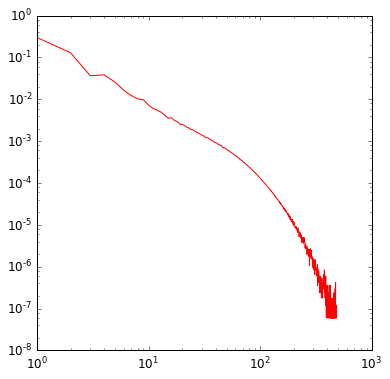

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))

    plt.loglog(ks,ek_unfltrd,'r',label='Unfiltered')

In [ ]:
kappa_c=100.0
## Filter the velocity field using the GAUSSIAN filter
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'gaussian')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'gaussian')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'gaussian')

ek_gaussian=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)    

    plt.loglog(ks,ek_gaussian,'g',label='Gaussian')
    
del cvx1
del cvy1
del cvz1

In [ ]:
kappa_c=100.0
## Filter the velocity field using the GAUSSIAN filter
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'sharp')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'sharp')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'sharp')

ek_sharp=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)    

    plt.loglog(ks,ek_sharp,'b',label='sharp')
    
del cvx1
del cvy1
del cvz1

In [ ]:
kappa_c=100.0
## Filter the velocity field using the GAUSSIAN filter
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'box')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'box')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'box')

ek_box=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)    

    plt.loglog(ks,ek_gaussian,'y',label='box')
    
del cvx1
del cvy1
del cvz1

In [ ]:
if my_id==0:
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.axis([0.0,1000.0, 1e-10,1.0])
    plt.legend(loc=0, shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)
    #plt.savefig('EnrgySpec_all.eps', format='eps', dpi=1200)

In [ ]:
sync=view.run('test4Class_Filters_all.py')
sync.display_outputs()

In [ ]:
nproc=rc[0].get('nproc')
for i in range(nproc):
    if(rc[i].get('my_id')==0):
        e0=rc[i]
        id_e0=i
        break

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

#matplotlib.rcParams.update({'font.size': 18})
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
#matplotlib.rc('xlabel', labelsize=20) 
#matplotlib.rc('ylabel', labelsize=20)
#axis_font = {'size':'14'} #{'fontname':'Arial', 'size':'14'}

SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
#plt.rc('figure', titlesize=SIZE)  # # size of the figure title


nek=e0.get('nek')
ks=np.linspace(1,nek,nek)
ek_all=e0.get('ek_all')
ek_gaussian=e0.get('ek_gaussian')
ek_sharp=e0.get('ek_sharp')
ek_box=e0.get('ek_box')

plt.figure(figsize=(6,6))
plt.loglog(ks,ek_all,'r',label='Unfiltered')
plt.loglog(ks,ek_gaussian,'b',label='Gaussian ($\kappa_c=100$)')
plt.loglog(ks,ek_sharp,'g',label='Sharp ($\kappa_c=100$)')
plt.loglog(ks,ek_box,'y',label='Box ($\kappa_c=100$)')
plt.loglog(ks,np.power(ks,-5/3),'k')
plt.loglog([100,100],[1.e-10,1],'k--')
plt.xlabel('$\kappa$')
plt.ylabel('$E(\kappa)$')
plt.axis([0.0,1000.0, 1e-10,1.0])
plt.legend(loc=0, shadow=True) #loc='upper center'
ax = plt.gca()
ax.set_autoscale_on(False)
plt.savefig('EnrgySpec_all.eps', format='eps', dpi=1200)